# Model Iterations:  Model 3

In this notebook, I continue to iterate upon models by employing convolutional neural networks. 

In [37]:
import os, shutil
import numpy as np
import random
np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

parent_dir = '../../'

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import modelling as m

In [3]:
# plot params:
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['savefig.directory'] = parent_dir + '/figures/'

In [4]:
val_folder = parent_dir + 'data/seg_val/'
test_folder = parent_dir + 'data/seg_test/'
train_folder = parent_dir + 'data/seg_train/'

## Prepare for Modelling

First, we'll reshape the images in all the different datasets and create data generators for them.  I choose batch sizes that are 10% of the size of the datasets - as I did for model 2.

In [5]:
# test generator:
test_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(test_folder, batch_size = 300)

# train generator:
train_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(train_folder, batch_size = 1123)

# val generator:
val_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(val_folder, batch_size = 280)

Found 3000 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_gen)
test_images, test_labels = next(test_gen)
val_images, val_labels = next(val_gen)

Next, let's reshape in the same way that we did for model 2:

In [7]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

train_y = np.reshape(train_labels[:,0], (1123, 1))
test_y = np.reshape(test_labels[:,0], (300, 1))
val_y = np.reshape(val_labels[:,0], (280, 1))

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(1123, 196608)
(300, 196608)
(280, 196608)
(1123, 1)
(300, 1)
(280, 1)


## Model 3:  CNN Model


In [8]:
model3 = Sequential()
# input layer
model3.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', 
                  input_shape = (256, 256, 3), data_format = "channels_last"))
model3.add(MaxPooling2D((2, 2)))
# hidden layer1
model3.add(Conv2D(128, (4, 4), activation = 'relu'))
model3.add(MaxPooling2D((2, 2)))
# hidden layer 2
model3.add(Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D((2, 2)))
# flatten layer
model3.add(Flatten())
# final dense layer
model3.add(Dense(32, activation = 'relu'))
# output layer
model3.add(Dense(6, activation = 'softmax'))

In [9]:
# compile
model3.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

In [10]:
# view the summary:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
__________

In [12]:
callback = EarlyStopping(patience = 3)
results3 = model3.fit(train_images, train_labels, epochs = 25, batch_size = 32, 
                      validation_data = (val_images, val_labels), callbacks = [callback])

Train on 1123 samples, validate on 280 samples
Epoch 1/25
1123/1123 [==============================] - 314s 280ms/step - loss: 1.7036 - acc: 0.2992 - val_loss: 1.3162 - val_acc: 0.4607
Epoch 2/25
1123/1123 [==============================] - 318s 283ms/step - loss: 1.2948 - acc: 0.4907 - val_loss: 1.3955 - val_acc: 0.3714
Epoch 3/25
1123/1123 [==============================] - 318s 283ms/step - loss: 1.1777 - acc: 0.5432 - val_loss: 1.1018 - val_acc: 0.5357
Epoch 4/25
1123/1123 [==============================] - 257s 229ms/step - loss: 1.0239 - acc: 0.5913 - val_loss: 1.0719 - val_acc: 0.5536
Epoch 5/25
1123/1123 [==============================] - 224s 199ms/step - loss: 0.9255 - acc: 0.6411 - val_loss: 1.1343 - val_acc: 0.5821
Epoch 6/25
1123/1123 [==============================] - 220s 195ms/step - loss: 0.8192 - acc: 0.6830 - val_loss: 0.9954 - val_acc: 0.6143
Epoch 7/25
1123/1123 [==============================] - 221s 197ms/step - loss: 0.6577 - acc: 0.7560 - val_loss: 0.9993 - val

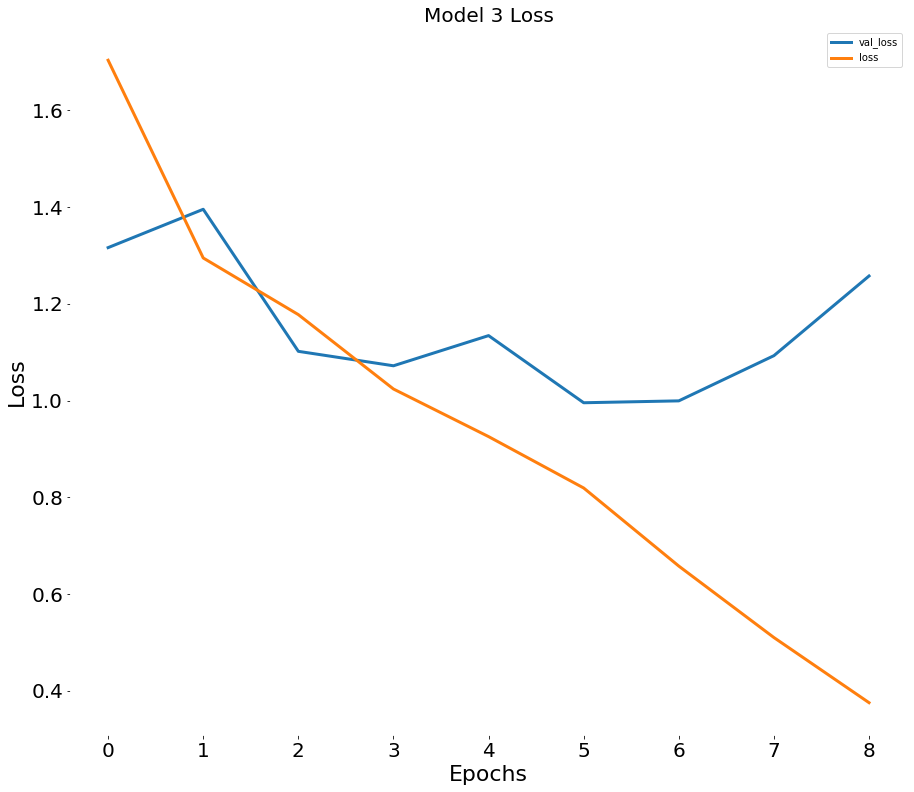

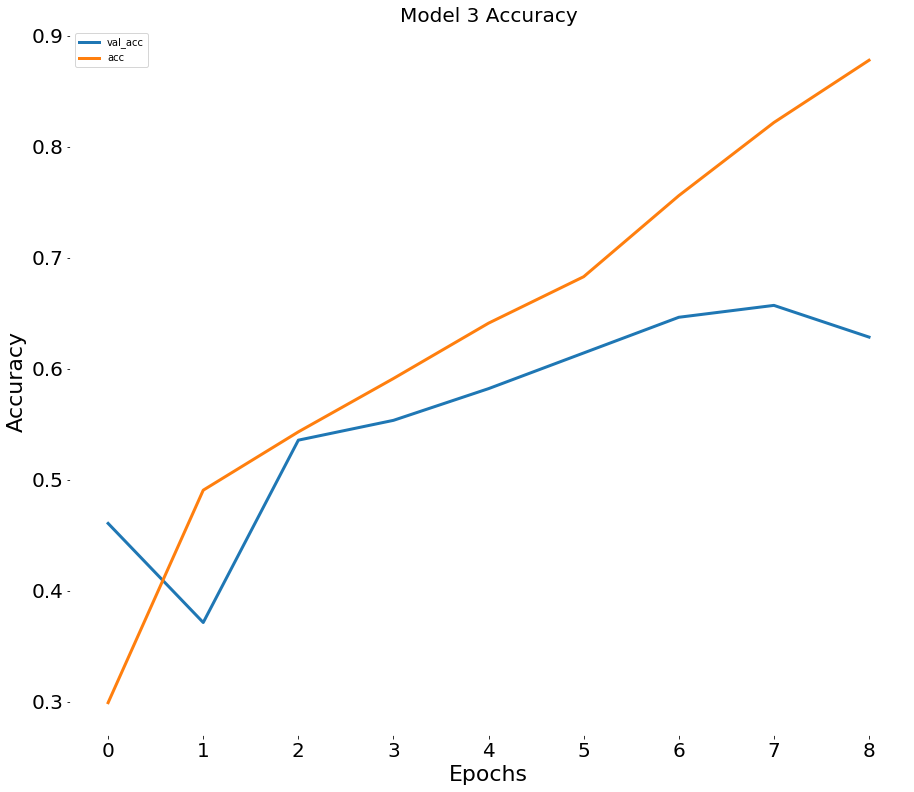

In [17]:
history = results3.history
plt.figure(figsize = (15, 13))
plt.plot(history['val_loss'], lw = 3)
plt.plot(history['loss'], lw = 3)
plt.legend(['val_loss', 'loss'])
plt.title('Model 3 Loss')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Loss', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model3_loss')
plt.show();

plt.figure(figsize = (15, 13))
plt.plot(history['val_acc'], lw = 3)
plt.plot(history['acc'], lw = 3)
plt.legend(['val_acc', 'acc'])
plt.title('Model 3 Accuracy')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model3_accuracy')
plt.show();

### Evaluate the model:

In [18]:
results_train = model3.evaluate(train_images, train_labels)

1123/1123 [==============================] - 70s 63ms/step


In [19]:
results_test = model3.evaluate(test_images, test_labels)

300/300 [==============================] - 20s 67ms/step


In [20]:
print(f'Train loss/accuracy:  {results_train}')
print(f'Test loss/accuracy:  {results_test}')

Train loss/accuracy:  [0.3462651653260072, 0.8682101514333078]
Test loss/accuracy:  [1.0978220287958782, 0.6199999992052714]


## Model iterations:  Model 3.1

### Run more epochs:

The model stopped running after just 9 epochs but does not seem to have converged and the validation loss looks like it is still increasing.  I'm going to try reducing the batch size to 32 and also take the early stopping out.  I will keep all layers the same.

In [24]:
# test generator:
test_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(test_folder, batch_size = 32)

# train generator:
train_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(train_folder, batch_size = 32)

# val generator:
val_gen = ImageDataGenerator(rescale = 1. / 255).flow_from_directory(val_folder, batch_size = 32)

Found 3000 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [25]:
# create the data sets
train_images, train_labels = next(train_gen)
test_images, test_labels = next(test_gen)
val_images, val_labels = next(val_gen)

## Model 3.1:  CNN Model with all 25 epochs and smaller batch size

In [27]:
model3_1 = Sequential()
# input layer
model3_1.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', 
                  input_shape = (256, 256, 3), data_format = "channels_last"))
model3_1.add(MaxPooling2D((2, 2)))
# hidden layer1
model3_1.add(Conv2D(128, (4, 4), activation = 'relu'))
model3_1.add(MaxPooling2D((2, 2)))
# hidden layer 2
model3_1.add(Conv2D(64, (3, 3), activation = 'relu'))
model3_1.add(MaxPooling2D((2, 2)))
# flatten layer
model3_1.add(Flatten())
# final dense layer
model3_1.add(Dense(32, activation = 'relu'))
# output layer
model3_1.add(Dense(6, activation = 'softmax'))

In [28]:
# compile
model3_1.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

In [29]:
results3_1 = model3_1.fit(train_images, train_labels, epochs = 25, batch_size = 32, 
                      validation_data = (val_images, val_labels))

Train on 32 samples, validate on 32 samples
Epoch 1/25
32/32 [==============================] - 8s 245ms/step - loss: 1.7896 - acc: 0.1250 - val_loss: 4.2930 - val_acc: 0.2188
Epoch 2/25
32/32 [==============================] - 8s 235ms/step - loss: 3.5226 - acc: 0.2500 - val_loss: 1.9735 - val_acc: 0.1562
Epoch 3/25
32/32 [==============================] - 8s 235ms/step - loss: 1.8250 - acc: 0.2812 - val_loss: 1.7833 - val_acc: 0.1562
Epoch 4/25
32/32 [==============================] - 8s 241ms/step - loss: 1.7144 - acc: 0.2812 - val_loss: 1.7972 - val_acc: 0.1562
Epoch 5/25
32/32 [==============================] - 8s 244ms/step - loss: 1.6164 - acc: 0.2812 - val_loss: 1.9535 - val_acc: 0.1562
Epoch 6/25
32/32 [==============================] - 8s 248ms/step - loss: 1.5579 - acc: 0.2812 - val_loss: 1.7338 - val_acc: 0.3125
Epoch 7/25
32/32 [==============================] - 8s 246ms/step - loss: 1.4833 - acc: 0.5625 - val_loss: 1.7346 - val_acc: 0.1875
Epoch 8/25
32/32 [==============

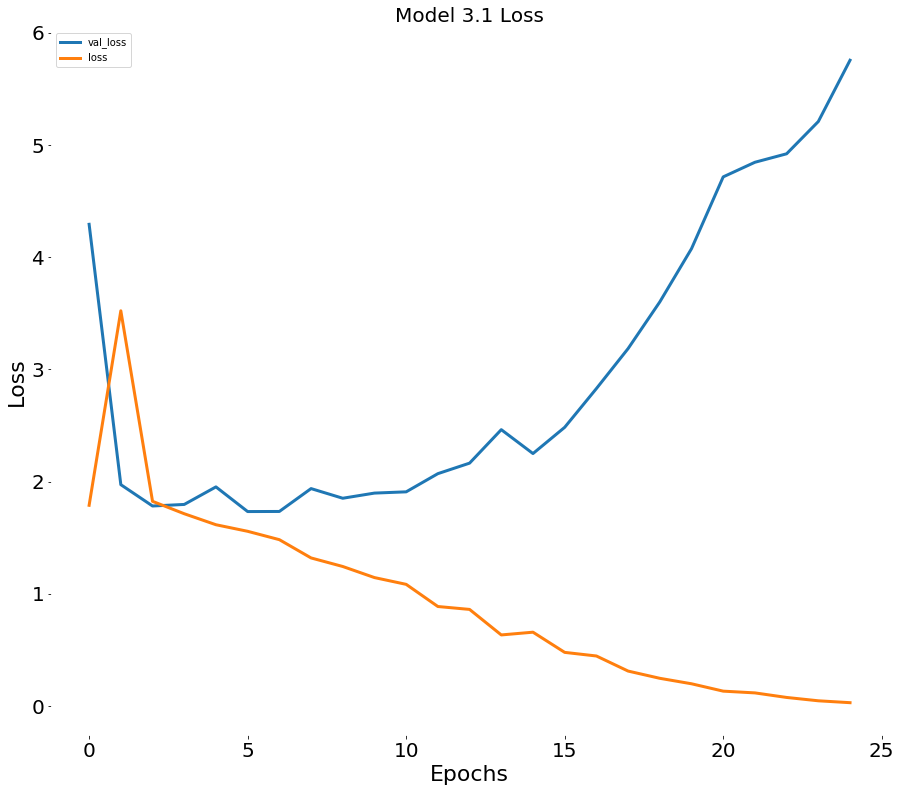

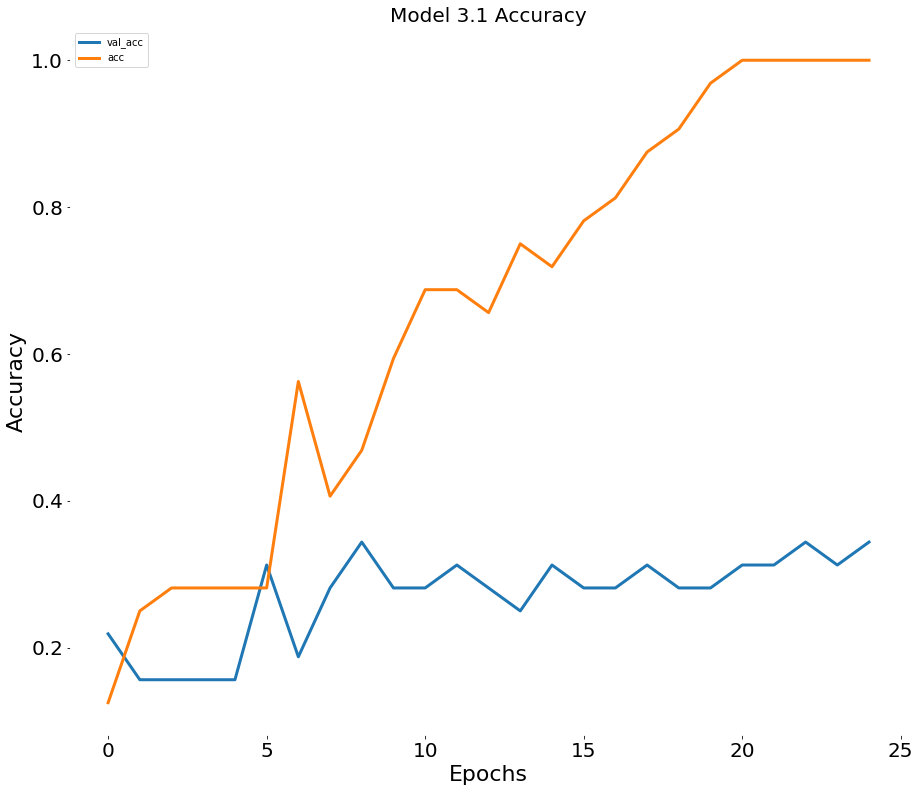

In [30]:
history = results3_1.history
plt.figure(figsize = (15, 13))
plt.plot(history['val_loss'], lw = 3)
plt.plot(history['loss'], lw = 3)
plt.legend(['val_loss', 'loss'])
plt.title('Model 3.1 Loss')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Loss', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model3_1_loss')
plt.show();

plt.figure(figsize = (15, 13))
plt.plot(history['val_acc'], lw = 3)
plt.plot(history['acc'], lw = 3)
plt.legend(['val_acc', 'acc'])
plt.title('Model 3.1 Accuracy')
plt.xlabel('Epochs', fontsize = 22)
plt.ylabel('Accuracy', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(parent_dir + 'figures/model3_1_accuracy')
plt.show();

### Evaluate

As you can see here, changing the batch size and epochs made the model even worse and more overfitted.  In the next model iteration I will look at hyperparameter tunning, now that we have a 'baseline' CNN to work from.  I will then try a model utilising transfer learning. 

In [32]:
results_train3_1 = model3_1.evaluate(train_images, train_labels)

32/32 [==============================] - 3s 79ms/step


In [33]:
results_test3_1 = model3_1.evaluate(test_images, test_labels)

32/32 [==============================] - 2s 62ms/step


In [34]:
print(f'Train loss/accuracy:  {results_train3_1}')
print(f'Test loss/accuracy:  {results_test3_1}')

Train loss/accuracy:  [0.01969488337635994, 1.0]
Test loss/accuracy:  [2.581747531890869, 0.5625]


## Model iterations:  Model 3.2

While we definitely need some hyperparameter tuning here, let's try some data augmentation to see if this increases our scores any better. 

### Data Augmentation:

The following parameters will rotate, flip, zoom and shift the images in the dataset.

In [31]:
train_aug_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.3, zoom_range = 0.1, 
                                   horizontal_flip = False)

Let's view some examples from the 'sea' class:

In [ ]:
names = [os.path.join(train_santa, name) for name in os.listdir(train_santa)]




img_path = names[91]
img = load_img(img_path, target_size=(64, 64))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

## NEVER MIND, going to do this in model 4

## Save Model 3:

In [35]:
model3.save(parent_dir + 'models/model3_save')

In [38]:
save_model(model3, filepath = parent_dir + 'models/model3', 
           overwrite = True, include_optimizer = True)

## Save Model 3.1:

In [39]:
model3_1.save(parent_dir + 'models/model3_1_save')

In [40]:
save_model(model3_1, filepath = parent_dir + 'models/model3_1', 
          overwrite = True, include_optimizer = True)